In [324]:
import numpy as np
import matplotlib.pyplot as plt
from spacepy import pycdf
from datetime import datetime, timedelta

In [16]:
# load datasets
magneto_cdf = pycdf.CDF('magnetometer.cdf')
image_cdf = pycdf.CDF('images.cdf')

## Relevant Data Schema

### magnetometor
- **thg_mag_rank (float)**: 3d magnetometor vector where each element is corresponding to North, East, Vertical Down, resceptively measured in $nT$
- **thg_mag_rank_time (float)**: integer representation of timetamp from $0:00$ to $23:59$ on $2008/2/10$

In [196]:
magneto_cdf

<CDF:
range_epoch: CDF_EPOCH [2]
thg_mag_rank: CDF_REAL4 [172800, 3]
thg_mag_rank_compno: CDF_INT4 [3] NRV
thg_mag_rank_epoch: CDF_EPOCH [0]
thg_mag_rank_epoch0: CDF_EPOCH [] NRV
thg_mag_rank_labl: CDF_CHAR*18 [3] NRV
thg_mag_rank_time: CDF_REAL8 [172800]
thg_mag_rank_unit: CDF_CHAR*2 [3] NRV
thg_magd_rank: CDF_REAL4 [0, 3]
thg_magh_rank: CDF_REAL4 [0, 3]
thg_magz_rank: CDF_REAL4 [0, 3]
>

In [194]:
print('Direction of magnetometor vectors')
for i, direction in enumerate(magneto_cdf['thg_mag_rank_labl']):
    print(f'Entry {i+1}: {direction}')

Direction of magnetometor vectors
Entry 1: Magnetic North - H
Entry 2: Magnetic East - E 
Entry 3: Vertical Down - Z 


### image

- **thg_asf_rank (int)**: 16-bit images (range of each pixel is [$0-65535$]) where size is $256\times256$
- **thg_asf_rank_epoch (datetime)**: timestamp from $5:00$ to $6:00$ on $2008/2/10$
- **thg_asf_rank_time (float)**: floating point representation of timetamp from $5:00$ to $6:00$ on $2008/2/10$

In [18]:
image_cdf

<CDF:
range_epoch: CDF_EPOCH [2]
thg_asf_rank: CDF_UINT2 [1200, 256, 256]
thg_asf_rank_column: CDF_UINT2 [256] NRV
thg_asf_rank_epoch: CDF_EPOCH [1200]
thg_asf_rank_epoch0: CDF_EPOCH [] NRV
thg_asf_rank_row: CDF_UINT2 [256] NRV
thg_asf_rank_tend: CDF_REAL8 [1200]
thg_asf_rank_time: CDF_REAL8 [1200]
>

Images are taken once in 3 seconds

In [199]:
image_cdf['thg_asf_rank_epoch'][:5]

array([datetime.datetime(2008, 2, 10, 5, 0, 0, 56000),
       datetime.datetime(2008, 2, 10, 5, 0, 3, 56000),
       datetime.datetime(2008, 2, 10, 5, 0, 6, 37000),
       datetime.datetime(2008, 2, 10, 5, 0, 9, 67000),
       datetime.datetime(2008, 2, 10, 5, 0, 12, 67000)], dtype=object)

## EDA

### magnetometor

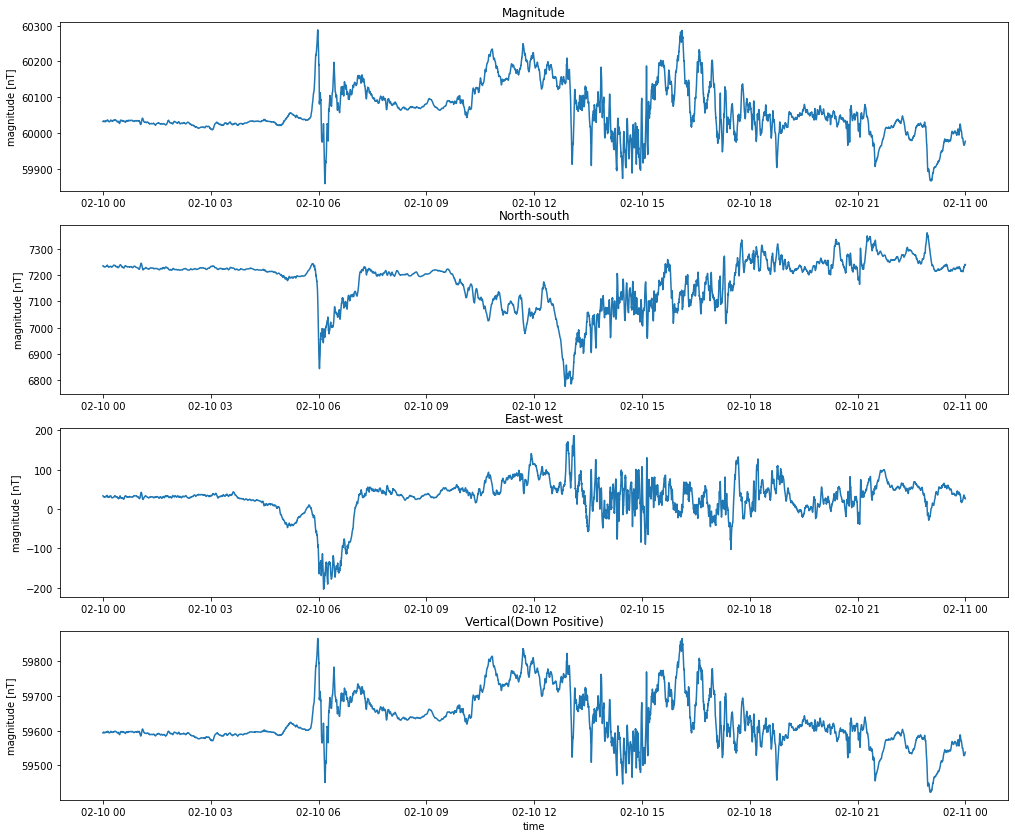

In [320]:
magnitude = np.sum(magneto_cdf['thg_mag_rank'][:] ** 2, axis=1) ** 0.5
t = np.arange(magneto_cdf['range_epoch'][0], datetime(2008, 2, 11, 0, 0, 0), timedelta(seconds=0.5)).astype(datetime)

ys = [magnitude, magneto_cdf['thg_mag_rank'][:, 0], magneto_cdf['thg_mag_rank'][:, 1], magneto_cdf['thg_mag_rank'][:, 2]]
titles = ["Magnitude", "North-south", "East-west", "Vertical(Down Positive)"]

fig, axs = plt.subplots(4, 1, figsize=(17, 12))
for ax, y, title in zip(axs, ys, titles):
    ax.plot(t, y)
    ax.set_title(title)
    ax.set_ylabel("magnitude [nT]")

# formatting
plt.subplots_adjust(bottom=0.1, top=1)
axs[-1].set_xlabel("time")
plt.show()

### Image Preprocessing for Print Use

In [139]:
def preprocess_image(images):
    normalized_images = []
    for image in images:
        new_image = image - np.percentile(image, 1) # subtract 1st percentile
        new_image = new_image / np.percentile(image, 99) # devide by 99th percentile
        new_image = np.maximum(np.zeros(new_image.shape), new_image) # set negative to 0
        new_image = np.minimum(np.ones(new_image.shape), new_image) # set upper bound to 1
        normalized_images.append(new_image)
    return normalized_images

normalized_images = preprocess_image(image_cdf['thg_asf_rank'])

The example plots of an image with and without aurora.

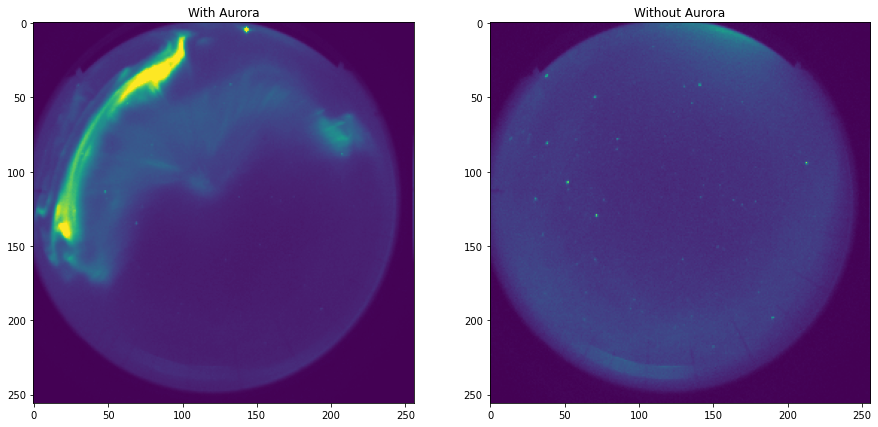

In [223]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))

ax1.imshow(normalized_images[1199])
ax1.set_title('With Aurora')

ax2.imshow(normalized_images[800])
ax2.set_title('Without Aurora')

plt.show()

### Average Brightness of Images

Note that we are working with raw 16-bit images and thus the range of each pixel is $[0, 65535]$. Images get brighter as time lapses, meaning aurora emerged around $5:45$.

In [235]:
mean_bright = np.mean(image_cdf['thg_asf_rank'], axis=(1, 2))

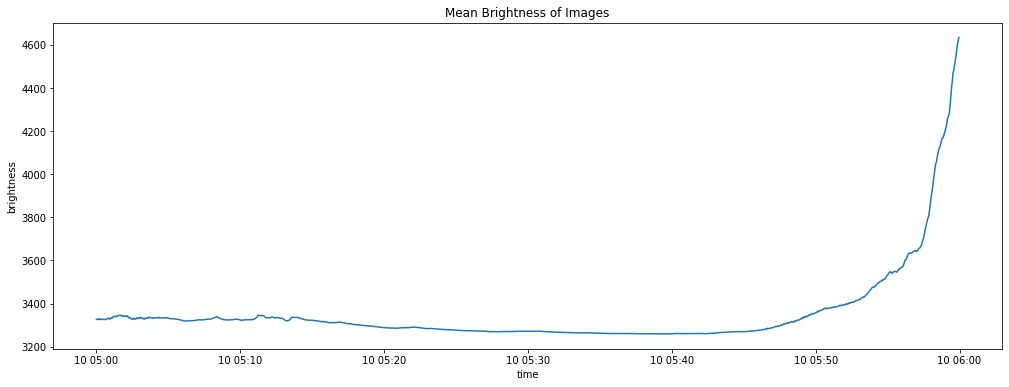

In [323]:
plt.figure(figsize=(17, 6))
plt.plot(image_cdf['thg_asf_rank_epoch'], mean_bright)
plt.title("Mean Brightness of Images")
plt.xlabel("time")
plt.ylabel("brightness")
plt.show()

### Relationship Between Brightness and Magnetometor

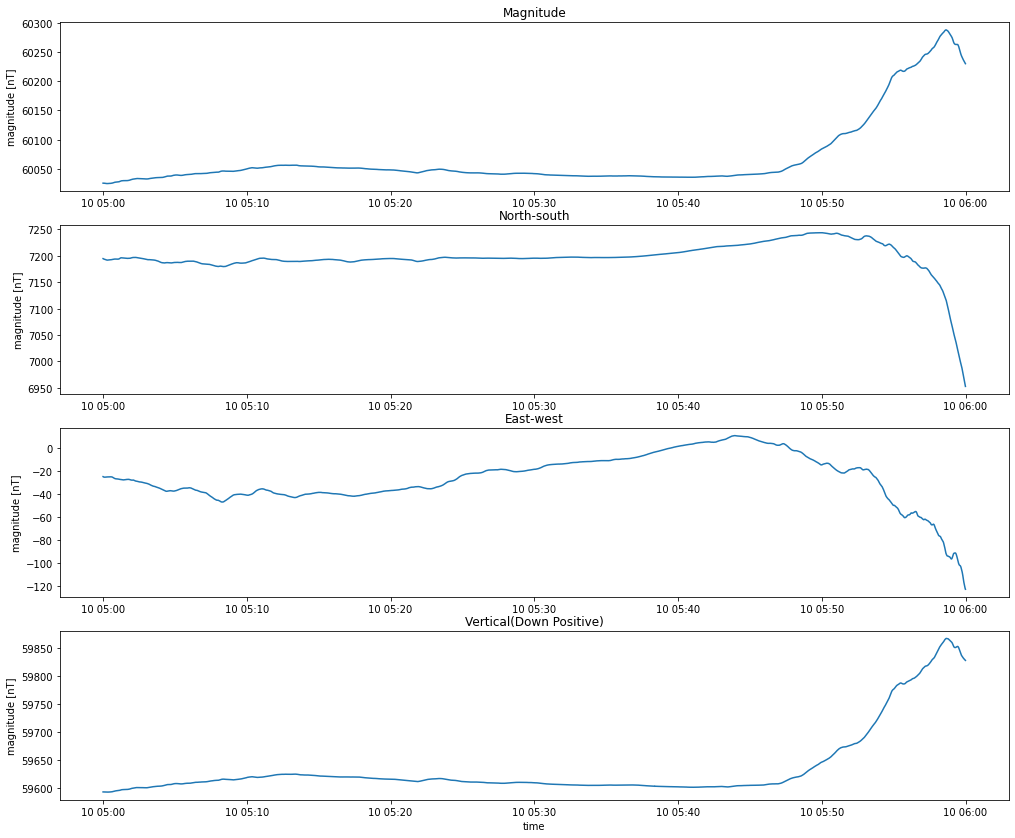

In [321]:
start = np.where(timestamp == datetime(2008, 2, 10, 5, 0, 0))[0][0]
end = np.where(timestamp == datetime(2008, 2, 10, 6, 0, 0))[0][0]

t2 = t[start:end]
ys2 = [magnitude[start:end], 
       magneto_cdf['thg_mag_rank'][start:end, 0], 
       magneto_cdf['thg_mag_rank'][start:end, 1],
       magneto_cdf['thg_mag_rank'][start:end, 2],]

fig, axs = plt.subplots(4, 1, figsize=(17, 12))
for ax, y, title in zip(axs, ys2, titles):
    ax.plot(t2, y)
    ax.set_title(title)
    ax.set_ylabel("magnitude [nT]")

# formatting
plt.subplots_adjust(bottom=0.1, top=1)
axs[-1].set_xlabel("time")
plt.show()

In [326]:
magneto_cdf['thg_mag_rank_epoch0']

<Var:
CDF_EPOCH [] NRV
>